In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from PIL import Image
import os
import sys
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


-----------------------
# Roadyroad

In [2]:
mode = 'rgb'

In [3]:
def load_image(infilename, mode='hsv'):
    data = mpimg.imread(infilename)
    if len(data.shape) == 3 and mode is 'hsv':
        data = rgb_to_hsv(data)
    return data

In [4]:
def save_image(outfilename, data):
    data3 = Image.fromarray((data * 255).astype(np.uint8))
    data3.save(outfilename)

In [84]:
root_dir = "./augmented_training/"

image_dir = root_dir + "satellite/"

n = 800
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + 'sat_{}.png'.format(i), mode) for i in range(n)]

gt_dir = root_dir + "ground_truth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + 'gt_{}.png'.format(i), mode) for i in range(n)]

Loading 800 images
Loading 800 images


In [85]:
imgs[0].shape

(400, 400, 3)

In [7]:
per = np.random.permutation(len(imgs))

imgs = np.asarray(imgs)
gt_imgs = np.asarray(gt_imgs)
imgs = imgs[per]
gt_imgs = gt_imgs[per]

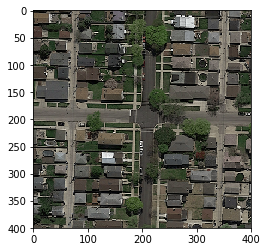

In [86]:
plt.imshow(imgs[4])

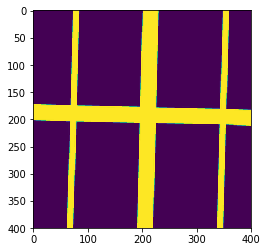

In [87]:
plt.imshow(gt_imgs[4])

In [88]:
batch_size = 32
epochs = 20
img_size = 400
test_img_size = 608
window_size = 72
patch_size = 16

In [89]:
def patch_mean(Y, index, patch_size):
    i = index[0]
    j = index[1]
    x_start = i - patch_size // 2
    x_end   = i + patch_size // 2 
    y_start = j - patch_size // 2
    y_end   = j + patch_size // 2
    
    Y_patch = Y[x_start : x_end, y_start : y_end]
    
    return np.mean(Y_patch)

def road_classification(Y, index, patch_size, threshold=0.5, verbose=False):
    '''Returned as (road, background)'''
    m = patch_mean(Y, index, patch_size)
    
    if verbose:
        if m > threshold:
            print('road')
        else:
            print('background')
    
    return np.array([int(m > threshold), int(m < threshold)])

In [90]:
def get_window(index, image, window_size):
    #assume window always fit into image
    #window_size have to be odd
    size = window_size // 2
    x1 = index[0] - size
    x2 = index[0] + size
    y1 = index[1] - size
    y2 = index[1] + size
    return image[x1 : x2, y1 : y2]

In [91]:
def extend_img(img, size):
    if (len(img.shape) == 3):
        r = np.pad(img[:, :, 0], size, 'reflect')
        g = np.pad(img[:, :, 1], size, 'reflect')
        b = np.pad(img[:, :, 2], size, 'reflect')
        return np.stack([r, g, b], axis=2)
    else:
        return np.pad(img, size, 'reflect')

In [92]:
def patch_indices(image_size,patch_size):
    indices = []
    for i in range(patch_size // 2,image_size,patch_size):
        for j in range(patch_size // 2,image_size,patch_size):
            indices.append(np.asarray([i,j]))
    
    return indices

def windows_from_img(img, window_size, patch_size):
    indices = patch_indices(img.shape[0], patch_size)
    ext_img = extend_img(img, window_size // 2)
    windows = []
    for index in indices:
        windows.append(get_window(index + window_size // 2, ext_img, window_size))
        
    return windows

def labels_from_gt_img(gt_img, window_size, patch_size):
    indices = patch_indices(gt_img.shape[0], patch_size)
    ext_gt_img = extend_img(gt_img, window_size // 2)
    labels = []
    for index in indices:
        labels.append(road_classification(ext_gt_img, index + window_size // 2, patch_size))
        
    return labels

In [93]:
def prediction_to_img(pred, img_size, patch_size):
    small_dim = img_size // patch_size
    small_img = (pred[:, 0] > 0.5).astype(int).reshape((small_dim, small_dim))
    return np.repeat(np.repeat(small_img, patch_size, axis=0), patch_size, axis=1)

In [94]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(window_size, window_size, 3)))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3)))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU())
model.add(Dropout(0.25))

model.add(Dense(2))
model.add(Activation('softmax'))

In [95]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  (None, 72, 72, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 68, 68, 32)        2432      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 68, 68, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 34, 34, 32)        128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        18496     
__________

In [96]:
windows = []
labels = []

for i in range(0, 800, 8):
    windows += windows_from_img(imgs[i], window_size, patch_size)
    labels += labels_from_gt_img(gt_imgs[i], window_size, patch_size)

windows = np.asarray(windows)
labels = np.asarray(labels)
print(windows.shape, labels.shape)

per = np.random.permutation(windows.shape[0])
windows = windows[per]
labels = labels[per]

(62500, 72, 72, 3) (62500, 2)


In [100]:
windows_test = []
labels_test = []

for i in range(1, 401, 8):
    windows_test += windows_from_img(imgs[i], window_size, patch_size)
    labels_test += labels_from_gt_img(gt_imgs[i], window_size, patch_size)

windows_test = np.asarray(windows_test)
labels_test = np.asarray(labels_test)
print(windows_test.shape, labels_test.shape)

per = np.random.permutation(windows_test.shape[0])
windows_test = windows_test[per]
labels_test = labels_test[per]

(31250, 72, 72, 3) (31250, 2)


[1 0]


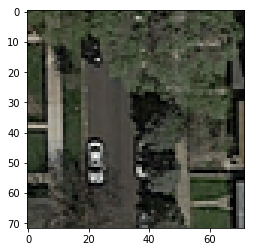

In [105]:
iii = np.random.randint(0, 100)
print(labels[iii])
plt.imshow(windows[iii])

In [106]:
cp = keras.callbacks.ModelCheckpoint('weights-Adam-CNN3v2.hdf5', monitor='acc', save_best_only=True, save_weights_only=True)

In [107]:
try:
    model.fit(windows, labels, batch_size, epochs=epochs, callbacks=[cp], validation_data=(windows_test, labels_test))
except KeyboardInterrupt:
    pass

Train on 62500 samples, validate on 31250 samples
Epoch 1/20
62500/62500 [==============================] - 132s 2ms/step - loss: 0.9073 - acc: 0.8243 - val_loss: 0.4367 - val_acc: 0.8194
Epoch 2/20
62500/62500 [==============================] - 146s 2ms/step - loss: 0.3229 - acc: 0.8630 - val_loss: 0.5853 - val_acc: 0.8432
Epoch 3/20
 2176/62500 [>.............................] - ETA: 1:53 - loss: 0.2849 - acc: 0.8888

In [108]:
test_windows = windows_from_img(imgs[200], window_size, patch_size)
test_windows = np.asarray(test_windows)

pred = model.predict(test_windows, batch_size)

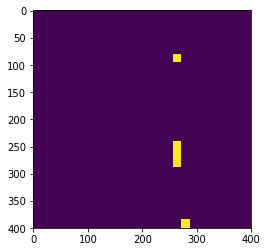

In [109]:
plt.imshow(prediction_to_img(pred, img_size, patch_size))

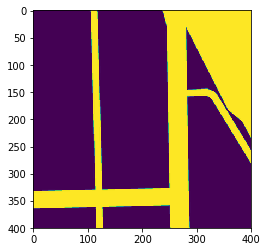

In [110]:
plt.imshow(gt_imgs[200])

In [111]:
def predict_window_set(to_predict_windows, batch_size):
    #x_test is the set of image, is a list
    return model.predict(to_predict_windows, batch_size)


In [112]:
from sklearn.metrics import classification_report
print(classification_report(labels_test, np.rint(predict_window_set(windows_test, batch_size)).astype(int)))

             precision    recall  f1-score   support

          0       0.43      0.06      0.11      5584
          1       0.83      0.98      0.90     25666

avg / total       0.76      0.82      0.76     31250



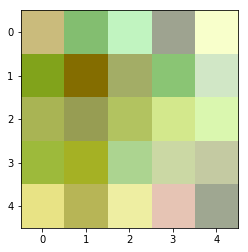

In [73]:
def map_(a):
    min_ = np.min(a)
    max_ = np.max(a)
    return (a - min_) / (max_ - min_)

plt.imshow(map_(model.layers[0].get_weights()[0][:, :, :, 11]))

In [114]:
for i in range(32):
    save_image('filters/filter_{}.png'.format(i), np.repeat(np.repeat(map_(model.layers[0].get_weights()[0][:, :, :, i]), 50, axis=0), 50, axis=1))

In [115]:
from scipy.signal import convolve2d

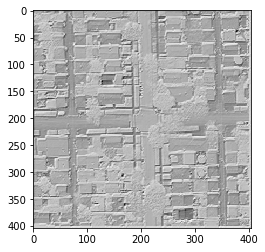

In [116]:
filter_0_0 = model.get_weights()[0][:, :, :, 17]
f_r = convolve2d(imgs[0][:, :, 0], filter_0_0[:, :, 0])
f_g = convolve2d(imgs[0][:, :, 1], filter_0_0[:, :, 1])
f_b = convolve2d(imgs[0][:, :, 2], filter_0_0[:, :, 2])
f = np.zeros((f_r.shape[0], f_r.shape[1], 3))
f[:, :, 0] = f_r
f[:, :, 1] = f_g
f[:, :, 2] = f_b
plt.imshow(f_r, cmap='Greys_r')

--------------------------
# Predict

In [83]:
nb_pred = 50
pred_path = './test_set_images/test_'
save_path = root_dir + 'prediction/'
for i in range(1,nb_pred+1):
    to_predict_img = load_image(pred_path+ str(i)+'/test_'+str(i)+'.png', mode)
    to_predict_windows = windows_from_img(to_predict_img, window_size, patch_size)
    to_predict_windows = np.asarray(to_predict_windows)
    pred = model.predict(to_predict_windows, batch_size)
    save_image(save_path + 'pred_' + str(i) + '.png', prediction_to_img(pred, test_img_size, patch_size))

In [81]:
ttt = load_image(pred_path+ str(1)+'/test_'+str(1)+'.png')

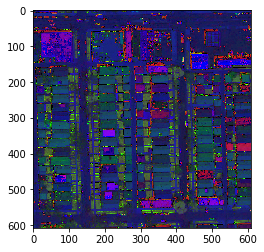

In [82]:
plt.imshow(ttt)